# Covid-19 Time Series Forecasting

In this notebook, I try to forecast time series of covid-19 using Recurrent Neural Networks (RNNs). Let's start with installing dependencies.

In [ ]:
pip install -r requirements.txt

Import dependecies.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Define dataset url.

In [2]:
URL = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

Download dataset.

In [3]:
dataset_path = tf.keras.utils.get_file(
        origin=URL,
        fname='dataset.csv')

Start reading dataset and display a few lines of each to get an idea.

In [4]:
df = pd.read_csv(dataset_path)
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,29/04/2020,29,4,2020,124,3,Afghanistan,AF,AFG,37172386.0,Asia
1,28/04/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
2,27/04/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
3,26/04/2020,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
4,25/04/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia


The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

Get number of rows of available with country name from data frame.

In [6]:
df_uk = df[df.countriesAndTerritories == 'United_Kingdom']
number_of_rows = len(df_uk)
number_of_rows

121

In [7]:
TRAIN_SPLIT = int((number_of_rows * 60) / 100)
TRAIN_SPLIT

72

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

We will train a model using only cases, and use it to make predictions for that value in the future.

In [9]:
uni_data = df_uk['cases']
uni_data.index = df_uk['dateRep']
uni_data.head()

dateRep
29/04/2020    3996
28/04/2020    4309
27/04/2020    4463
26/04/2020    4913
25/04/2020    5386
Name: cases, dtype: int64

Draw a graph of dataframe to see how it looks like.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e840eb8>],
      dtype=object)

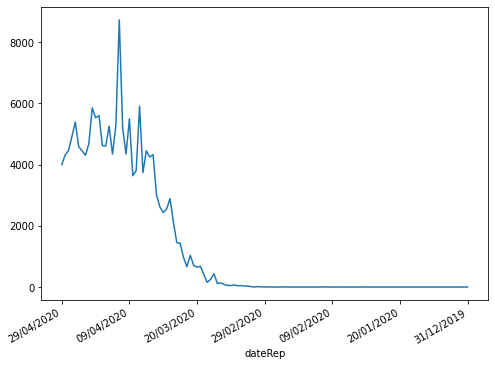

In [10]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

Scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Standardize the data.

In [13]:
uni_data = (uni_data - uni_train_mean) / uni_train_std